# Test plane extraction for a single point cloud

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import time
import open3d as o3d

import planeslam.general as general
from planeslam.mesh import LidarMesh
from planeslam.scan import Scan
from planeslam.clustering import cluster_mesh_graph_search, mesh_cluster_pts
#from planeslam.extraction import scan_from_clusters

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Read Point Cloud from pcd file

In [2]:
# Read in point cloud data
pcfile = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_100.pcd')
pcd = o3d.io.read_point_cloud(pcfile)
P = np.asarray(pcd.points)

In [3]:
# Convert points to ENU
P = general.NED_to_ENU(P)

# Downsample the points
P = general.downsample(P, factor=5, axis=0)

Text(0.5, 0.5, 'Y')

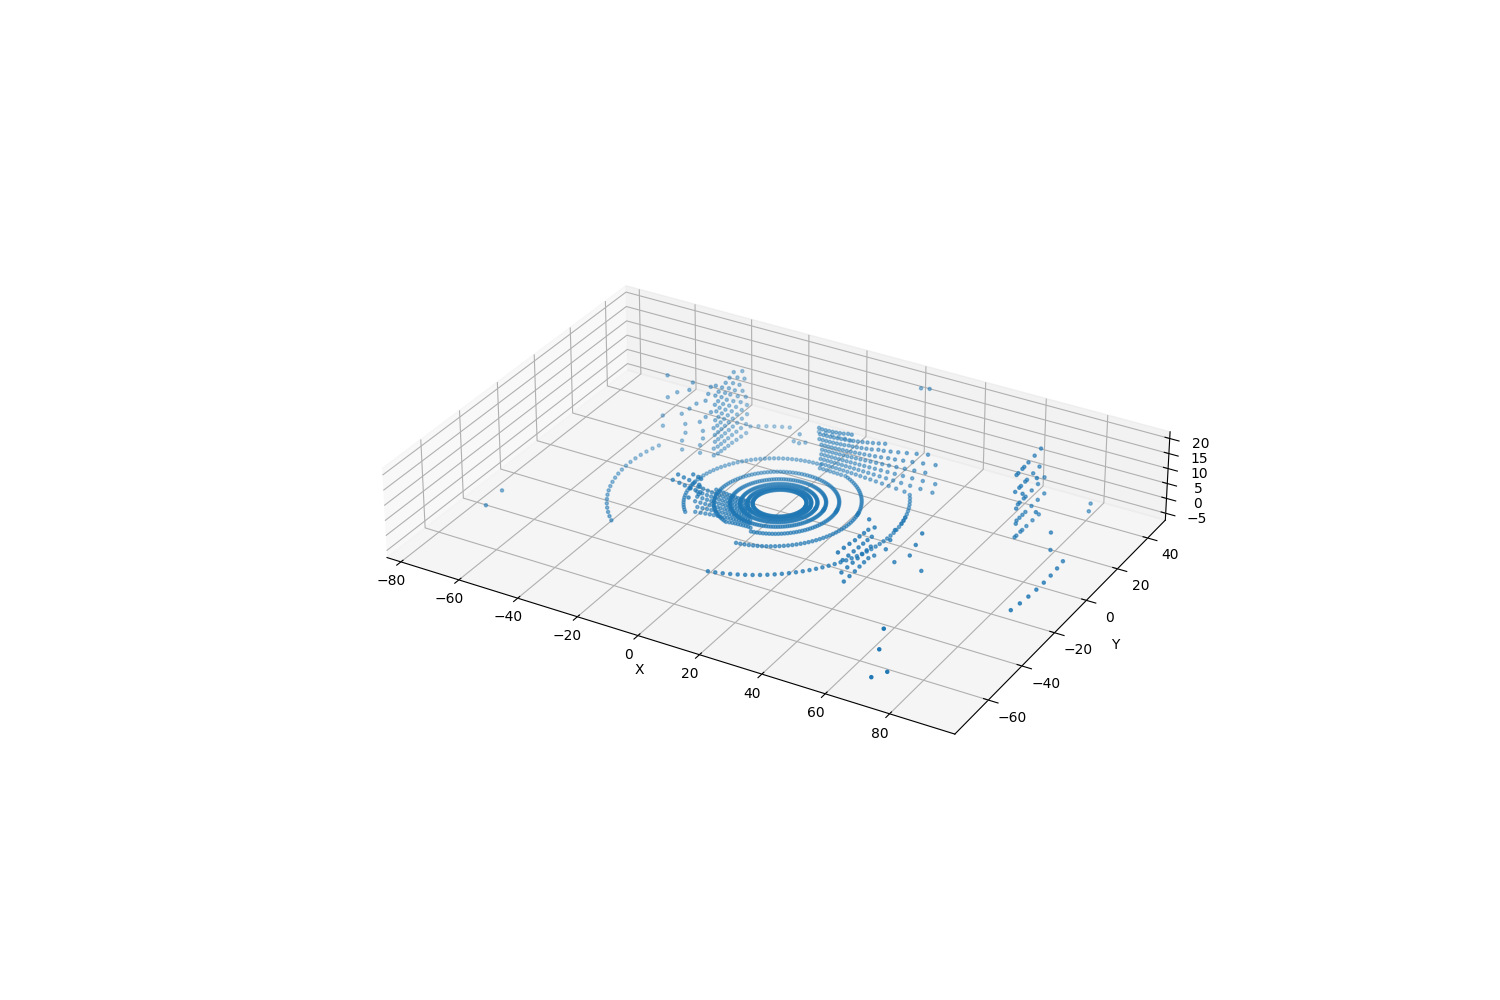

In [4]:
# Plot the points
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter3D(P[:,0], P[:,1], P[:,2], marker='.')  

ax.set_box_aspect((np.ptp(P[:,0]), np.ptp(P[:,1]), np.ptp(P[:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")

Cluster the points

In [5]:
# Create the mesh
mesh = LidarMesh(P)
mesh.prune(10)
start_time = time.time()
# Cluster the mesh with graph search
clusters, avg_normals = cluster_mesh_graph_search(mesh)
print("elapsed time: ", time.time() - start_time)

elapsed time:  0.3121628761291504


Text(0.5, 0.5, 'Y')

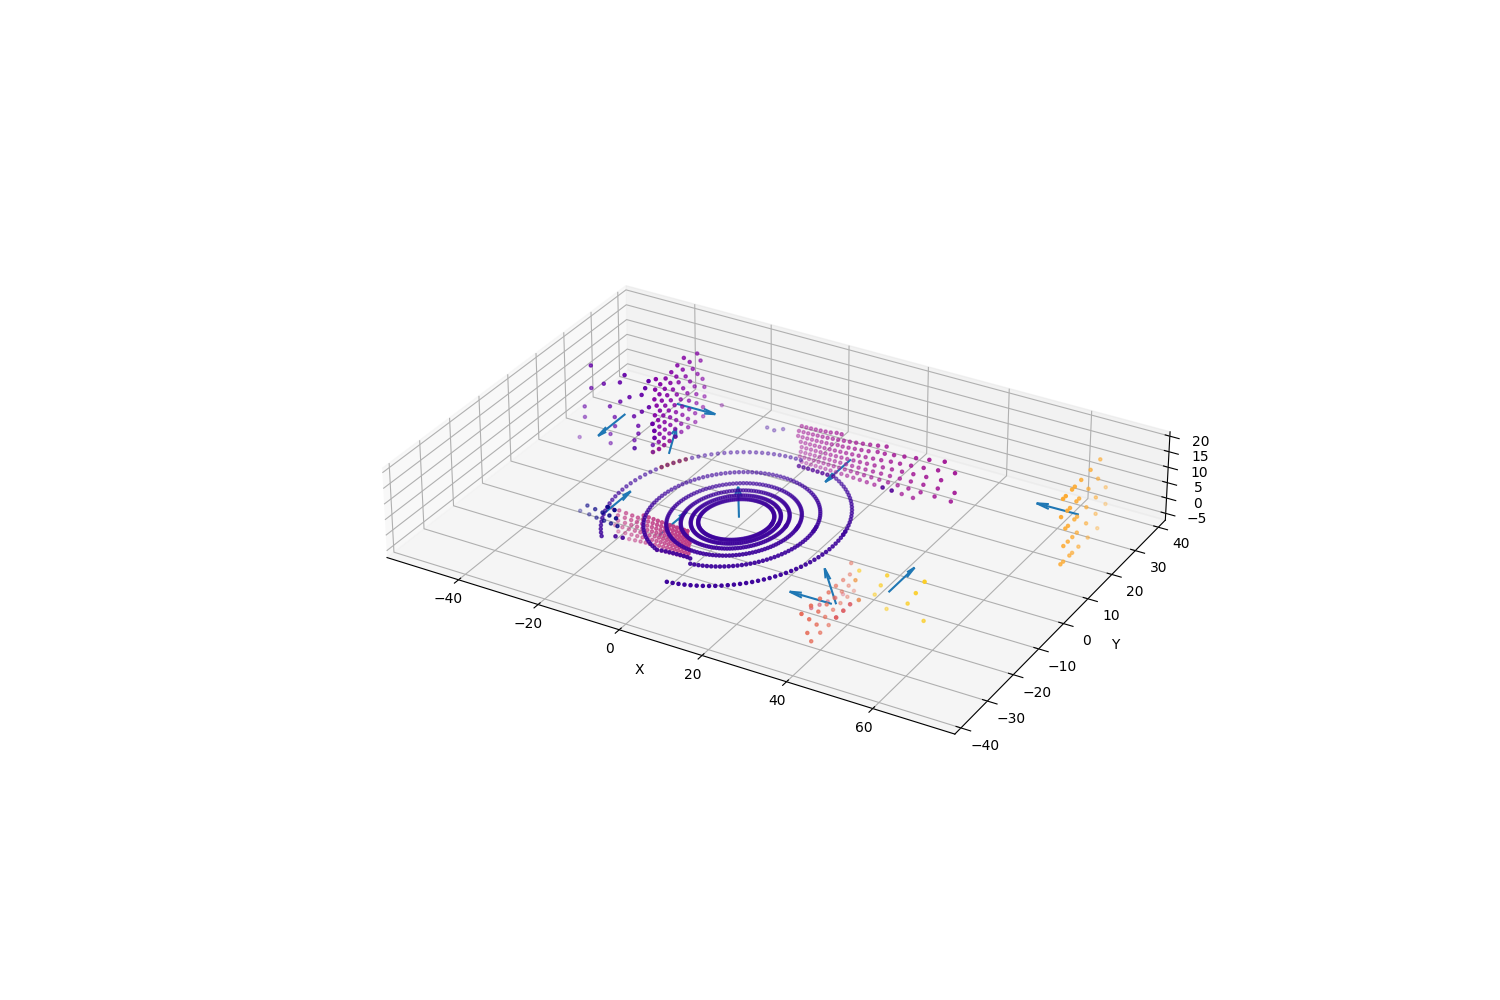

In [6]:
# Plot clusters
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cmap = cm.get_cmap('plasma')
cmap_idxs = int(len(cmap.colors) / len(clusters)) * np.arange(len(clusters))
colors = np.asarray(cmap.colors)[cmap_idxs,:]
for i, c in enumerate(clusters):
    cluster_pts = mesh_cluster_pts(mesh, c)
    ax.scatter3D(cluster_pts[:,0], cluster_pts[:,1], cluster_pts[:,2], color=colors[i,:], marker='.')  

    # Show normals
    c = np.mean(cluster_pts, axis=0)
    n = 10 * avg_normals[i]
    ax.quiver(c[0], c[1], c[2], n[0], n[1], n[2])

ax.set_box_aspect((np.ptp(P[:,0]), np.ptp(P[:,1]), np.ptp(P[:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")


Extract planes

In [44]:
from planeslam.extraction import bd_plane_from_pts
from planeslam.clustering import sort_mesh_clusters
from planeslam.geometry.plane import BoundedPlane

def scan_from_clusters(mesh, clusters, avg_normals, vertex_merge_thresh=1.0):
    """Convert clustered points to network of planes

    Parameters
    ----------
    mesh : LidarMesh
        Mesh object for clusters
    clusters : list of lists
        Point indices grouped into clusters (based on surface normals and locality)
    avg_normals : list of np.array (3 x 1)
        Average normal vector for each cluster of points
    vertex_merge_thresh : float
        Distance between vertices in order to merge them

    Returns
    -------
    planes : list
        List of BoundedPlanes
    vertices : np.array (n_verts x 3)
        Ordered array of vertices in scan
    faces : np.array (n_faces, 4)
        Sets of 4 vertex indices which form a face

    """
    # TODO: merge planes which are inside other planes into each other

    vertices = []
    faces = []  
    planes = []
    vertex_counter = 0

    # Sort clusters from largest to smallest
    clusters, avg_normals = sort_mesh_clusters(clusters, avg_normals)

    for i, c in enumerate(clusters):  
        n = avg_normals[i][:,None]
        cluster_pts = mesh_cluster_pts(mesh, c)  # Extract points from cluster

        # Extract bounding plane
        plane_pts = bd_plane_from_pts(cluster_pts, n)
        new_face = -np.ones(4, dtype=int)  # New face indices
        new_mask = np.ones(4, dtype=bool)  # Which of the new plane points to keep (i.e. not reused)
        
        # Check if this plane shares any vertices with previous planes
        for i in range(len(vertices)):
            dists = np.linalg.norm(plane_pts - vertices[i], axis=1)
            best_match = np.argsort(dists)[0]
            if dists[best_match] < vertex_merge_thresh:
                new_face[best_match] = i
                new_mask[best_match] = False

        # If shared, adjust plane accordingly
        if sum(new_mask) < 4:
            if sum(new_mask) == 2:
                 print(new_mask)
                 anchor_idxs = new_face[new_face!=-1]
                 anchor_verts = np.asarray(vertices)[anchor_idxs]

                 print("anchors: ", np.asarray(vertices)[anchor_idxs])

        # Otherwise, add all new vertices
        else:
            pass
        # Set new face indices
        for i in range(4):
            if new_face[i] == -1:
                new_face[i] = vertex_counter
                vertex_counter += 1

        vertices += list(plane_pts[new_mask,:])
        faces.append(new_face)
        planes.append(BoundedPlane(np.asarray(vertices)[new_face,:]))

    vertices = np.asarray(vertices)
    faces = np.asarray(faces)
    
    return planes, vertices, faces


from planeslam.general import normalize


# "Merge plane"
def mask_to_basis(mask, anchor_verts, old_verts, normal):
    """Mask to basis
    
    Mask indicates which vertices from old_vertices are being merged with
    the anchors (and also which vertices in the plane the anchors belong to)

    [True, True, False, False] = v2 - v1 = x
    [False, True, True, False] = v3 - v2 = y
    [False, False, True, True] = v4 - v3 = -x
    [True, False, False, True] = v4 - v1 = y

    """
    new_verts = np.empty((4,3))

    if np.all(mask == [True, True, False, False]):
        basis_x = normalize(np.diff(anchor_verts, axis=0))
        basis_y = np.cross(normal.T, basis_x)
        S2_len = np.linalg.norm(old_verts[2] - old_verts[1])
        v3_new = anchor_verts[1] + S2_len * basis_y
        v4_new = anchor_verts[0] + S2_len * basis_y
        new_verts[2] = v3_new
        new_verts[3] = v4_new
        new_verts[mask] = anchor_verts

    elif np.all(mask == [False, True, True, False]):
        basis_y = normalize(np.diff(anchor_verts, axis=0))
        basis_x = np.cross(basis_y, normal.T)
        print(basis_x)
        S1_len = np.linalg.norm(old_verts[1] - old_verts[0])
        v4_new = anchor_verts[1] - S1_len * basis_x
        v1_new = anchor_verts[0] - S1_len * basis_x
        new_verts[0] = v1_new
        new_verts[3] = v4_new
        new_verts[mask] = anchor_verts

    elif np.all(mask == [False, False, True, True]):
        basis_x = -normalize(np.diff(anchor_verts, axis=0))
        basis_y = np.cross(normal.T, basis_x)
        S2_len = np.linalg.norm(old_verts[2] - old_verts[1])
        v2_new = anchor_verts[0] - S2_len * basis_y
        v1_new = anchor_verts[1] - S2_len * basis_y
        new_verts[0] = v1_new
        new_verts[1] = v2_new
        new_verts[mask] = anchor_verts
    
    elif np.all(mask == [True, False, False, True]):
        basis_y = normalize(np.diff(anchor_verts, axis=0))
        basis_x = np.cross(basis_y, normal.T)
        S1_len = np.linalg.norm(old_verts[1] - old_verts[0])
        v3_new = anchor_verts[1] + S1_len * basis_x
        v2_new = anchor_verts[0] + S1_len * basis_x
        new_verts[2] = v3_new
        new_verts[1] = v2_new
        new_verts[mask] = anchor_verts

    else:
        print("Not a valid mask")
    
    return new_verts

In [48]:
anchor_verts = np.array([[1, -1, 0.1], [1, 1, 0]])
old_verts = np.array([[-1, -1, 0], [1, -1, 0], [1, 1, 0], [-1, 1, 0]])
normal = np.array([0, 0, 1])[:,None]
mask = np.array([False, True, True, False])

[[ 0.99875234 -0.          0.        ]]
[[-0.99750468 -1.          0.1       ]
 [ 1.         -1.          0.1       ]
 [ 1.          1.          0.        ]
 [-0.99750468  1.          0.        ]]


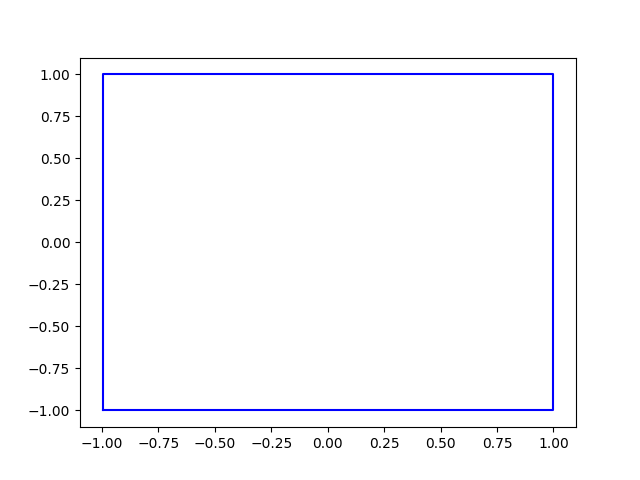

In [49]:
from planeslam.geometry.rectangle import Rectangle
new_verts = mask_to_basis(mask, anchor_verts, old_verts, normal)
print(new_verts)
rect = Rectangle(new_verts)
rect.plot()

In [29]:
new_verts

array([[-1. , -1.1,  0. ],
       [ 1. , -1.1,  0. ],
       [ 1. ,  0.9,  0. ],
       [-1. ,  0.9,  0. ]])

In [10]:
planes, vertices, faces = scan_from_clusters(mesh, clusters, avg_normals)
scan = Scan(planes, vertices, faces)

[ True False False  True]
[12 15]
anchors:  [[-30.05545345  13.1008936   -5.01526107]
 [-30.46184186  13.10230045  19.47810916]]


AssertionError: Side lengths from vertices given to BoundedPlane constructor are not equal

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

scan.plot(ax, color='r', show_normals=True)

ax.set_box_aspect((np.ptp(P[:,0]), np.ptp(P[:,1]), np.ptp(P[:,2])))
ax.set_xlabel("X")
ax.set_ylabel("Y")